## Credit Risk Model

#### Importing necessary libraries

In [1]:
import os
import sys
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sidetable as stb
import scorecardpy as sc
from monotonic_binning.monotonic_woe_binning import Binning

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

In [2]:
sys.path.append(os.path.abspath('../scripts'))

from Utils import DataUtils, WoE
from Plotting import Plots

data_utils = DataUtils()
plotting = Plots()
woe = WoE()

#### Weight of Evidence (WoE) 

In [3]:
filepath = '../data/data.csv'

data = data_utils.load_data(filepath)
data.drop('TransactionStartTime', inplace=True, axis=1)

2024-10-07 23:08 - DEBUG :: Loading data from file...


In [4]:
data.stb.freq(['RiskResult'], style = True)

,RiskResult,count,percent,cumulative_count,cumulative_percent
0,0,"72,077",75.35%,"72,077",75.35%
1,1,"23,585",24.65%,"95,662",100.00%


In [5]:
# ProductCategory - check categories
data.stb.freq(['ProductCategory'], style = True)

,ProductCategory,count,percent,cumulative_count,cumulative_percent
0,financial_services,"45,405",47.46%,"45,405",47.46%
1,airtime,"45,027",47.07%,"90,432",94.53%
2,utility_bill,"1,920",2.01%,"92,352",96.54%
3,data_bundles,"1,613",1.69%,"93,965",98.23%
4,tv,"1,279",1.34%,"95,244",99.56%
5,ticket,216,0.23%,"95,460",99.79%
6,movies,175,0.18%,"95,635",99.97%
7,transport,25,0.03%,"95,660",100.00%
8,other,2,0.00%,"95,662",100.00%


In [6]:
data['STD_Transaction_Amount'] =data['STD_Transaction_Amount'].fillna(0)

In [7]:
data.isna().sum().sum()

np.int64(0)

#### Calculating Weight of Evidence

In [8]:
train, test = train_test_split(data, test_size=0.3, random_state=42)

In [9]:
# Creating columns to bin
ids = ['TransactionId','BatchId', 'AccountId', 'SubscriptionId', 'CustomerId', 'CurrencyCode','CountryCode']
train = train.drop(ids, axis=1)

num_cols = train.select_dtypes(include=['int64', 'float64']).columns
columns_to_bin = num_cols

In [10]:
# Creating bins
bin_edges_dict = {} 

for col in columns_to_bin:
    train[col + '_bin'], bin_edges = pd.qcut(train[col], q=20, duplicates='drop', retbins=True)
    bin_edges_dict[col] = bin_edges
     

In [11]:
cols = ['Amount', 'Value', 'PricingStrategy', 'Transaction_Hour', 'Transaction_Month', 'Transaction_year', 'Transaction_Day', 'Total_transaction_amount', 'Average_transaction_amount', 'Transaction_Count', 'STD_Transaction_Amount', 'Recency', 'Frequency',
        	'ProviderId',	'ProductCategory',	'ChannelId','FraudResult', 'ProductId']
train_bins = train.drop(cols, axis=1)

In [12]:
train_bins.head()

,RiskResult,ProviderId_bin,ProductId_bin,ChannelId_bin,Amount_bin,Value_bin,PricingStrategy_bin,FraudResult_bin,Transaction_Hour_bin,Transaction_Month_bin,Transaction_year_bin,Transaction_Day_bin,Total_transaction_amount_bin,Average_transaction_amount_bin,Transaction_Count_bin,STD_Transaction_Amount_bin,Recency_bin,Frequency_bin,RiskResult_bin
24030,0,"(3.0, 4.0]","(-0.001, 1.0]","(1.0, 2.0]","(5000.0, 10000.0]","(5000.0, 8000.0]","(2.0, 4.0]","(-0.001, 1.0]","(11.0, 12.0]","(11.0, 12.0]","(2017.999, 2019.0]","(11.0, 12.0]","(129000.0, 160000.0]","(4080.464, 4545.455]","(32.0, 42.0]","(5388.207, 5863.302]","(59.0, 63.0]","(32.0, 42.0]","(-0.001, 1.0]"
72484,1,"(4.0, 5.0]","(9.0, 16.0]","(1.0, 2.0]","(1000.0, 2000.0]","(1200.0, 2000.0]","(-0.001, 2.0]","(-0.001, 1.0]","(14.0, 15.0]","(0.999, 2.0]","(2017.999, 2019.0]","(24.0, 25.0]","(563380.0, 708936.0]","(1264.848, 1431.486]","(483.0, 778.0]","(3691.719, 4263.608]","(15.0, 18.0]","(483.0, 778.0]","(-0.001, 1.0]"
18789,0,"(-0.001, 3.0]","(17.0, 19.0]","(-0.001, 1.0]","(-900000.001, -5000.0]","(2660.0, 5000.0]","(-0.001, 2.0]","(-0.001, 1.0]","(5.0, 6.0]","(11.0, 12.0]","(2017.999, 2019.0]","(5.0, 7.0]","(201511.3, 248497.25]","(1177.39, 1264.848]","(164.0, 205.0]","(3691.719, 4263.608]","(63.0, 68.0]","(164.0, 205.0]","(-0.001, 1.0]"
84442,1,"(4.0, 5.0]","(9.0, 16.0]","(1.0, 2.0]","(500.0, 1000.0]","(500.0, 1000.0]","(-0.001, 2.0]","(-0.001, 1.0]","(16.0, 17.0]","(0.999, 2.0]","(2017.999, 2019.0]","(2.0, 4.0]","(2628793.0, 83451240.0]","(1905.086, 2050.414]","(778.0, 2085.0]","(7051.483, 7715.39]","(7.0, 11.0]","(778.0, 2085.0]","(-0.001, 1.0]"
2677,0,"(4.0, 5.0]","(1.0, 2.0]","(1.0, 2.0]","(500.0, 1000.0]","(500.0, 1000.0]","(-0.001, 2.0]","(-0.001, 1.0]","(18.0, 19.0]","(2.0, 11.0]","(2017.999, 2019.0]","(16.0, 18.0]","(404694.0, 563380.0]","(2912.817, 3367.806]","(117.0, 139.0]","(21603.476, 38535.622]","(84.0, 90.0]","(117.0, 139.0]","(-0.001, 1.0]"


In [13]:
IV_df = woe.compute_iv(train_bins)

In [14]:
IV_df

,Variable,IV
0,ProviderId_bin,0.221055
1,ProductId_bin,0.131194
2,ChannelId_bin,0.104869
3,Amount_bin,0.434584
4,Value_bin,0.407859
5,PricingStrategy_bin,0.029026
6,FraudResult_bin,0.000000
7,Transaction_Hour_bin,0.095474
8,Transaction_Month_bin,0.179092
9,Transaction_year_bin,0.000000


In [15]:
# Useless columns
IV_df.loc[(IV_df['IV'] < 0.02)]

,Variable,IV
6,FraudResult_bin,0.0
9,Transaction_year_bin,0.0
17,RiskResult_bin,0.0


In [16]:
# Weak predictive power
IV_df.loc[(IV_df['IV'] > 0.02) & (IV_df['IV'] < 0.1)]

,Variable,IV
5,PricingStrategy_bin,0.029026
7,Transaction_Hour_bin,0.095474


In [17]:
# Medium predictive power
IV_df.loc[(IV_df['IV'] > 0.1) & (IV_df['IV'] < 0.3)]

,Variable,IV
0,ProviderId_bin,0.221055
1,ProductId_bin,0.131194
2,ChannelId_bin,0.104869
8,Transaction_Month_bin,0.179092
10,Transaction_Day_bin,0.224070


In [18]:
# strong predictive power
IV_df.loc[(IV_df['IV'] > 0.3) & (IV_df['IV'] < 0.5)]

,Variable,IV
3,Amount_bin,0.434584
4,Value_bin,0.407859
15,Recency_bin,0.436503


In [19]:
# Have very strong predictive power: Too good to be true
IV_df.loc[(IV_df['IV'] > 0.5)]

,Variable,IV
11,Total_transaction_amount_bin,2.239408
12,Average_transaction_amount_bin,1.512002
13,Transaction_Count_bin,0.845142
14,STD_Transaction_Amount_bin,1.557070
16,Frequency_bin,0.845142


**Observation**
- From the above values we can see that these columns don't have any predictive power or are useless:
    * FraudResult_bin
    * Transaction_year_bin
- These columns have weak predictive power:
    * PricingStrategy_bin
    * Transaction_Month_bin
- These columns have medium predictive power:
    * ProviderId_bin
    * ChannelId_bin
    * ProductId_bin
    * Transaction_Month_bin
    * Transaction_Day_bin
- These columns have strong predictive power:
    * Recency_bin
    * Amount_bin
    * Value_bin 
- Thses columns have more predictive power than the realistic amount:
    * Frequency_bin
    * STD_Transaction_Amount_bin
    * Transaction_Count_bin
    * Average_transaction_amount_bin
    * Total_transaction_amount_bin

    

#### Creating score cards

In [20]:
# Filtering the dataset
dt_s = sc.var_filter(data, y="RiskResult")

[INFO] filtering variables ...
Variable filtering on 95662 rows and 26 columns in 00:01:26 
6 variables are removed


In [21]:
dt_s.head()

,Recency,SubscriptionId,Total_transaction_amount,PricingStrategy,ProductId,STD_Transaction_Amount,Amount,ChannelId,Transaction_Count,CustomerId,Frequency,AccountId,Transaction_Hour,ProviderId,Transaction_Day,ProductCategory,Average_transaction_amount,Transaction_Month,Value,RiskResult
0,90,3535,109921.75,2,1,3042.294251,1000.0,2,119,2584,119,2490,2,5,15,airtime,923.712185,11,1000,0
1,90,2366,109921.75,2,19,3042.294251,-20.0,1,119,2584,119,3219,2,3,15,financial_services,923.712185,11,20,0
2,90,996,1000.00,2,0,0.000000,500.0,2,2,2806,2,2713,2,5,15,airtime,500.000000,11,500,0
3,90,974,228727.20,2,11,17169.241610,20000.0,2,38,3733,38,3351,3,0,15,utility_bill,6019.136842,11,21800,0
4,90,2366,228727.20,2,19,17169.241610,-644.0,1,38,3733,38,3219,3,3,15,financial_services,6019.136842,11,644,0


In [25]:
bins = sc.woebin(dt_s, y="RiskResult")

[INFO] creating woe binning ...
Binning on 95662 rows and 20 columns in 00:00:20


#### Scorecard

{'Recency': <Figure size 640x480 with 2 Axes>,
 'SubscriptionId': <Figure size 640x480 with 2 Axes>,
 'Total_transaction_amount': <Figure size 640x480 with 2 Axes>,
 'PricingStrategy': <Figure size 640x480 with 2 Axes>,
 'ProductId': <Figure size 640x480 with 2 Axes>,
 'STD_Transaction_Amount': <Figure size 640x480 with 2 Axes>,
 'Amount': <Figure size 640x480 with 2 Axes>,
 'ChannelId': <Figure size 640x480 with 2 Axes>,
 'Transaction_Count': <Figure size 640x480 with 2 Axes>,
 'Frequency': <Figure size 640x480 with 2 Axes>,
 'CustomerId': <Figure size 640x480 with 2 Axes>,
 'AccountId': <Figure size 640x480 with 2 Axes>,
 'Transaction_Hour': <Figure size 640x480 with 2 Axes>,
 'ProviderId': <Figure size 640x480 with 2 Axes>,
 'Transaction_Day': <Figure size 640x480 with 2 Axes>,
 'ProductCategory': <Figure size 640x480 with 2 Axes>,
 'Average_transaction_amount': <Figure size 640x480 with 2 Axes>,
 'Transaction_Month': <Figure size 640x480 with 2 Axes>,
 'Value': <Figure size 640x480

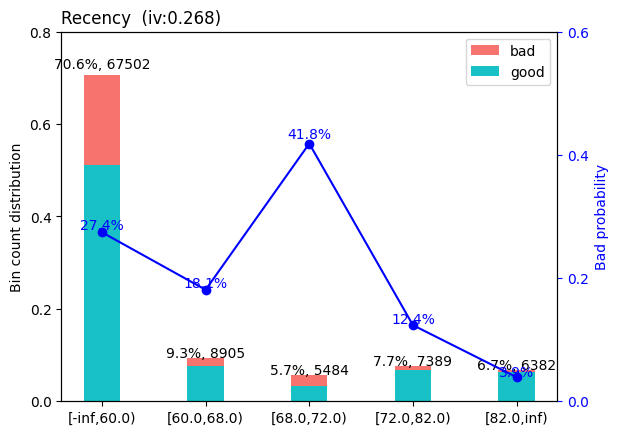

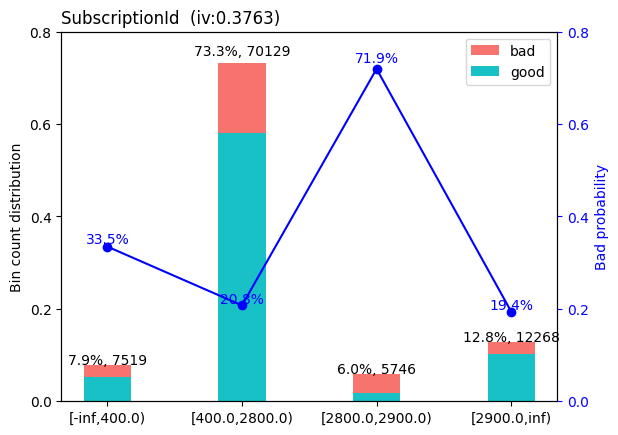

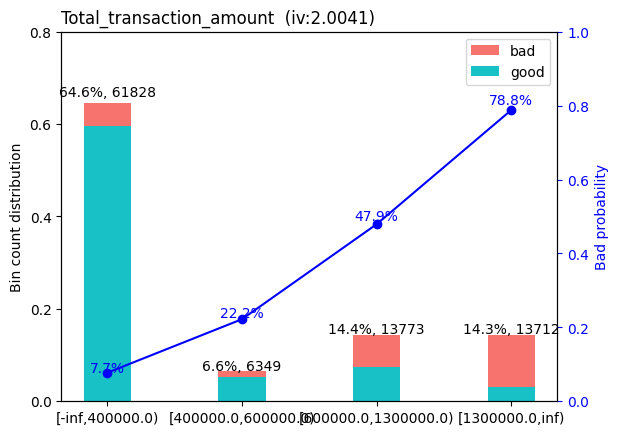

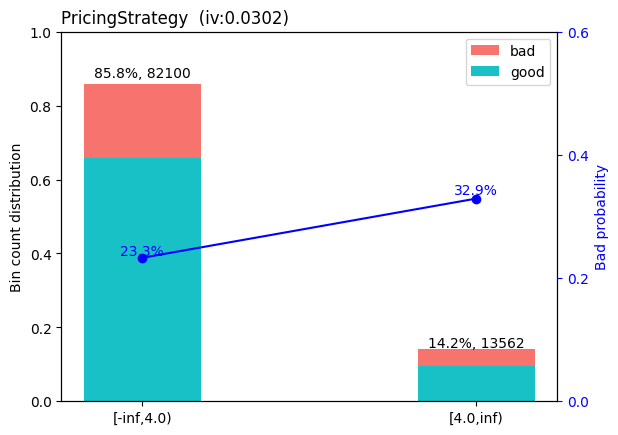

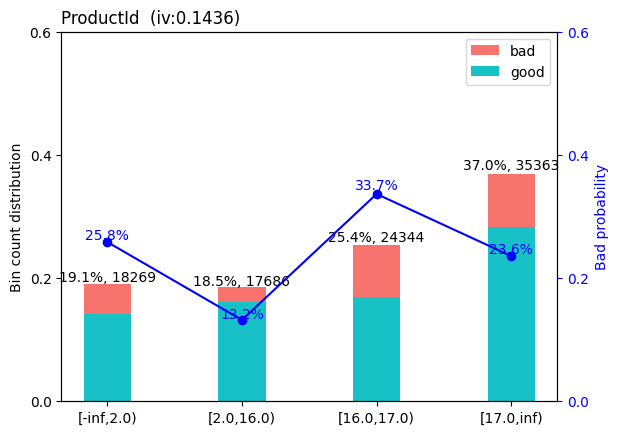

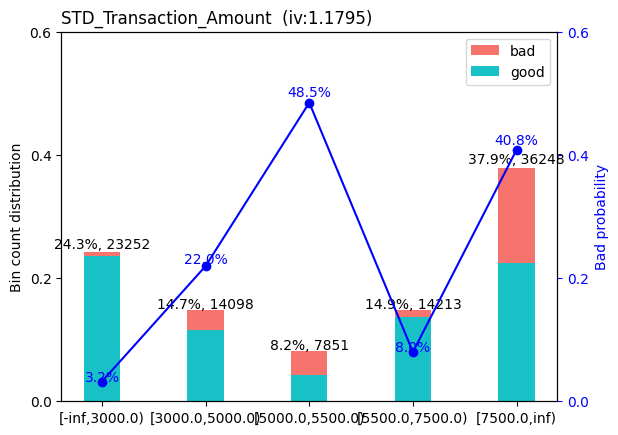

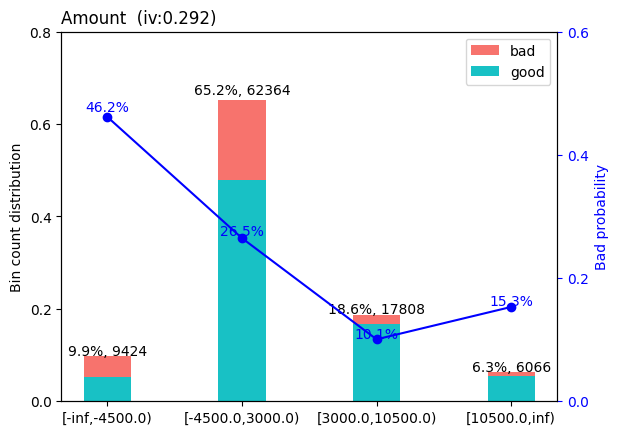

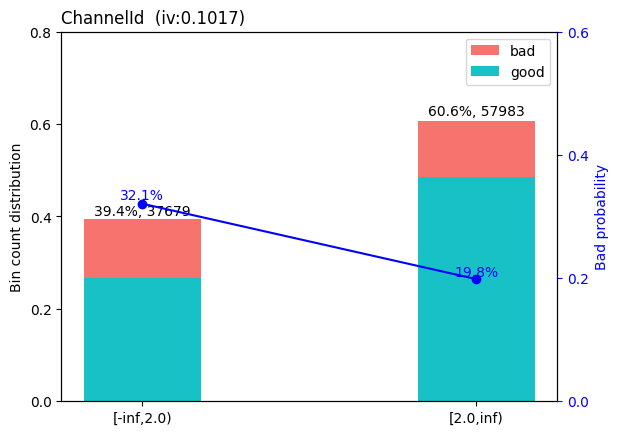

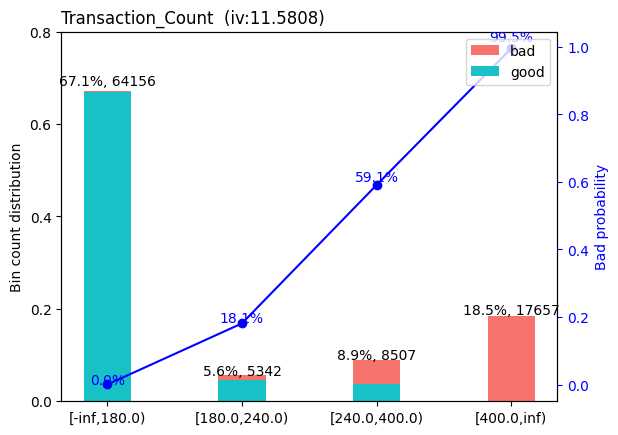

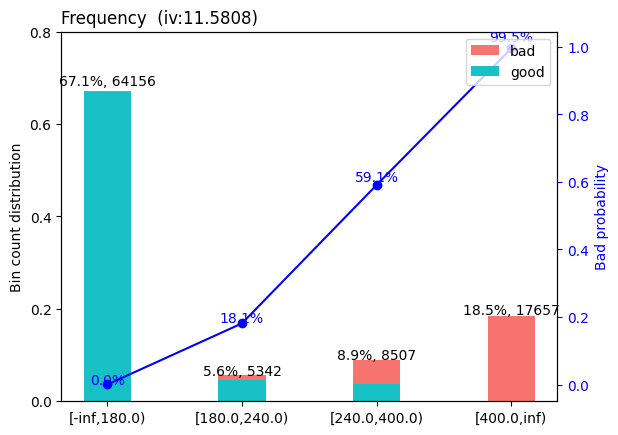

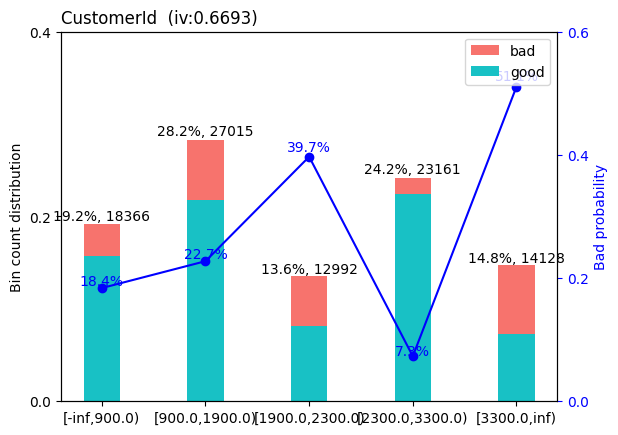

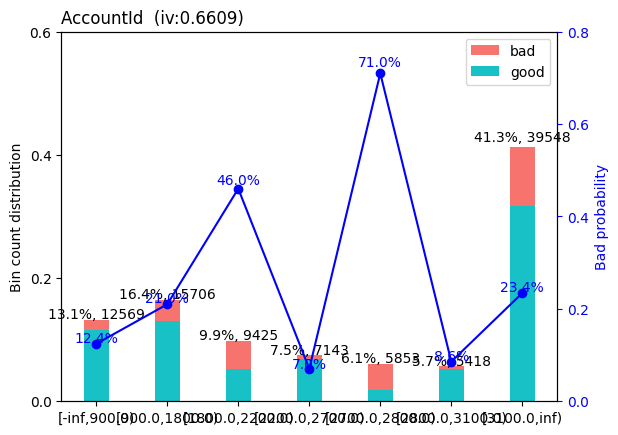

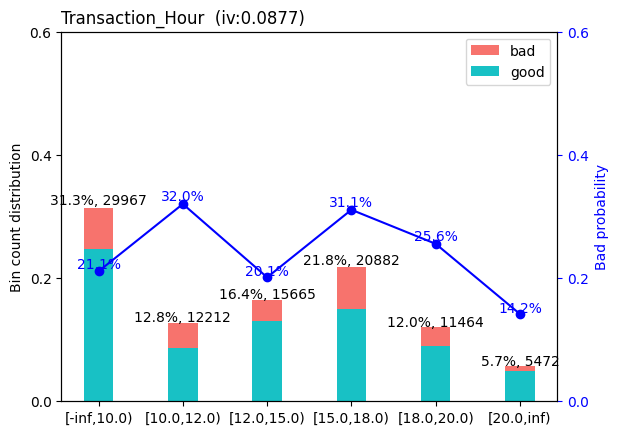

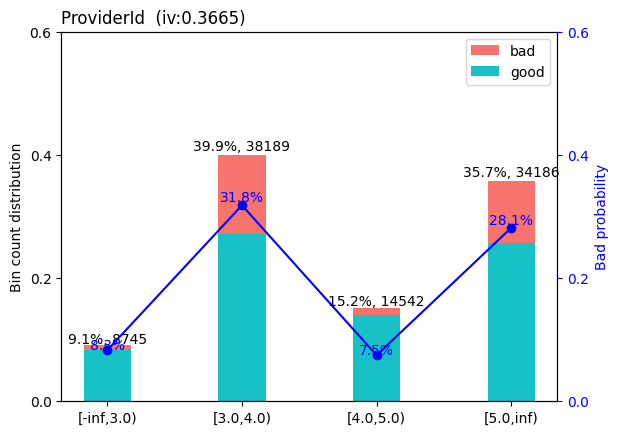

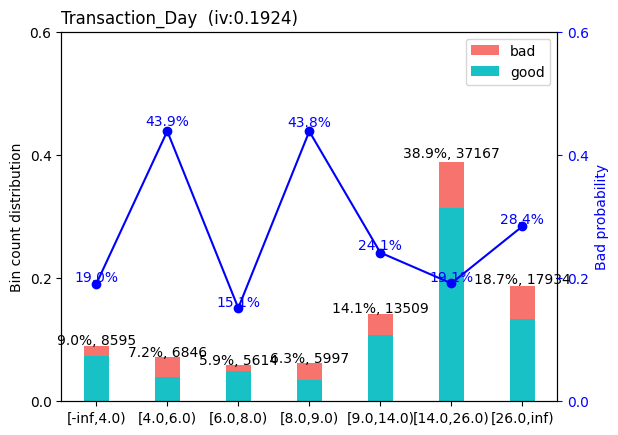

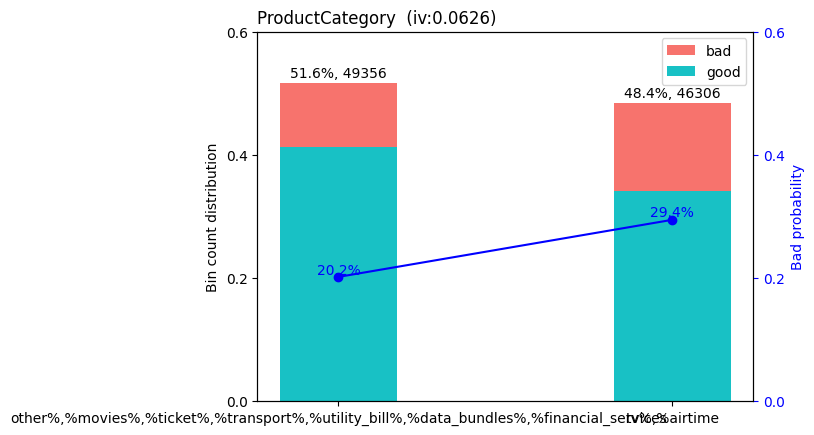

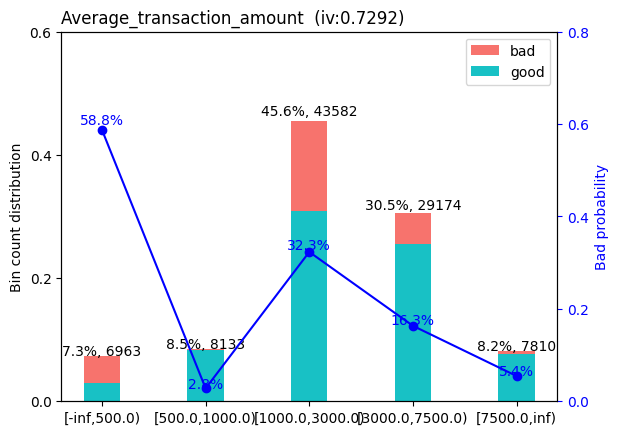

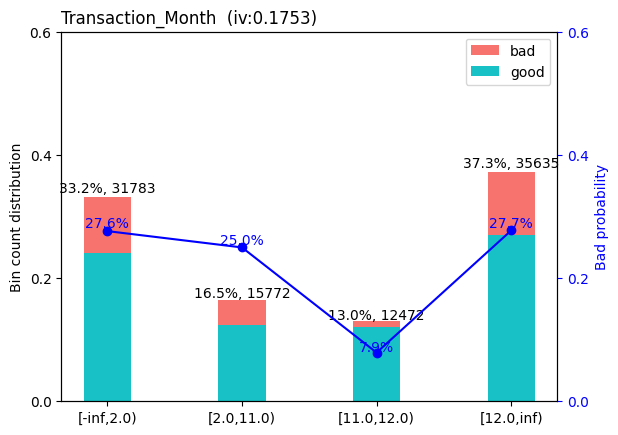

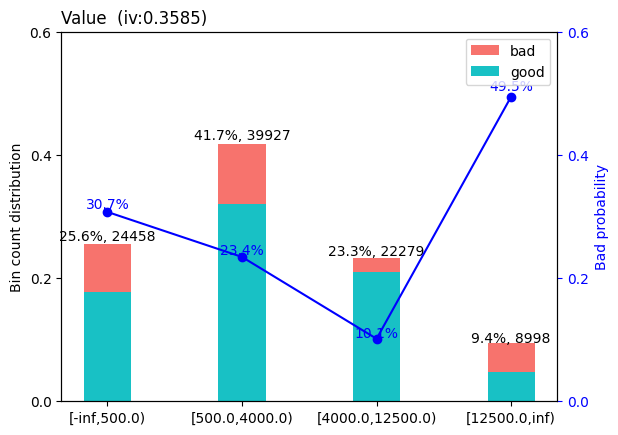

In [27]:
sc.woebin_plot(bins)